# 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd

import random as rd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore")

# 데이터 로드

In [2]:
filepath = 'https://github.com/mchoimis/tsdl/raw/main/sales/'

sales = pd.read_csv(filepath + 'train.csv')
item_cat = pd.read_csv(filepath + 'item-category.csv')
item = pd.read_csv(filepath + 'items.csv')
shops = pd.read_csv(filepath + 'shops.csv')
test = pd.read_csv(filepath + 'test.csv')

In [3]:
print(shops.info())
shops.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [4]:
print(sales.info())
print(sales.isnull().sum())

sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
print(item_cat.info())
print(item_cat.isnull().sum())

item_cat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
item_category_name    0
item_category_id      0
dtype: int64


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y')) # UDF로 time index 만들기
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


# Simple EDA

In [7]:
# Aggregate to monthly level
monthly_sales = sales.groupby(["date_block_num", "shop_id", "item_id"])[["date", "item_price", "item_cnt_day"]].agg({"date":["min",'max'], "item_price":"mean", "item_cnt_day":"sum"})
monthly_sales

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
...                                   ...        ...        ...          ...
33             59      22087   2015-10-05 2015-10-23      119.0          6.0
                       22088   2015-10-03 2015-10-27      119.0          2.0
                       22091   2015-10-03 2015-10-03      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

[1609124 rows x 4 columns]

In [8]:
# Number of items per category
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id', ascending=False)

# 아이템 수 상위 10개 카테고리
x = x.iloc[0:10].reset_index()[['item_category_id', 'item_id']].rename(columns={'item_id' : 'item_cnt'})
x

,item_category_id,item_cnt
0,40,5035
1,55,2365
2,37,1780
3,31,1125
4,58,790
5,30,756
6,72,666
7,19,628
8,61,598
9,23,501


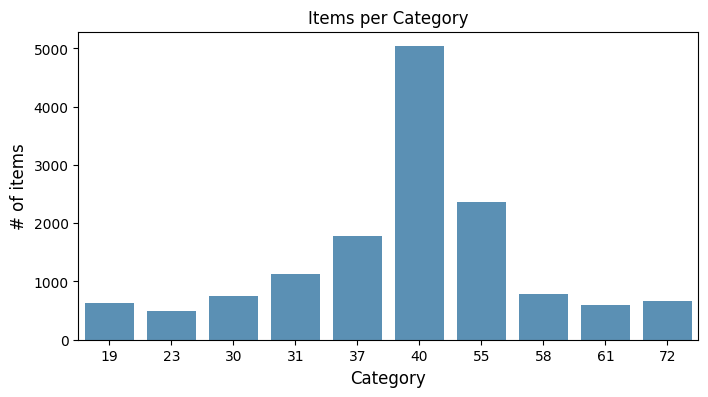

In [9]:
# Visualize # Cross-sectional
plt.figure(figsize=(8,4))
ax= sns.barplot(data=x, x='item_category_id', y='item_cnt', alpha=0.8)

plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)

plt.show()

In [10]:
# 일별 상품 구매 건수 데이터 생성
ts = sales.groupby(["date"])["item_cnt_day"].sum()
ts.astype('float')
ts

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
               ...  
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: item_cnt_day, Length: 1034, dtype: float64

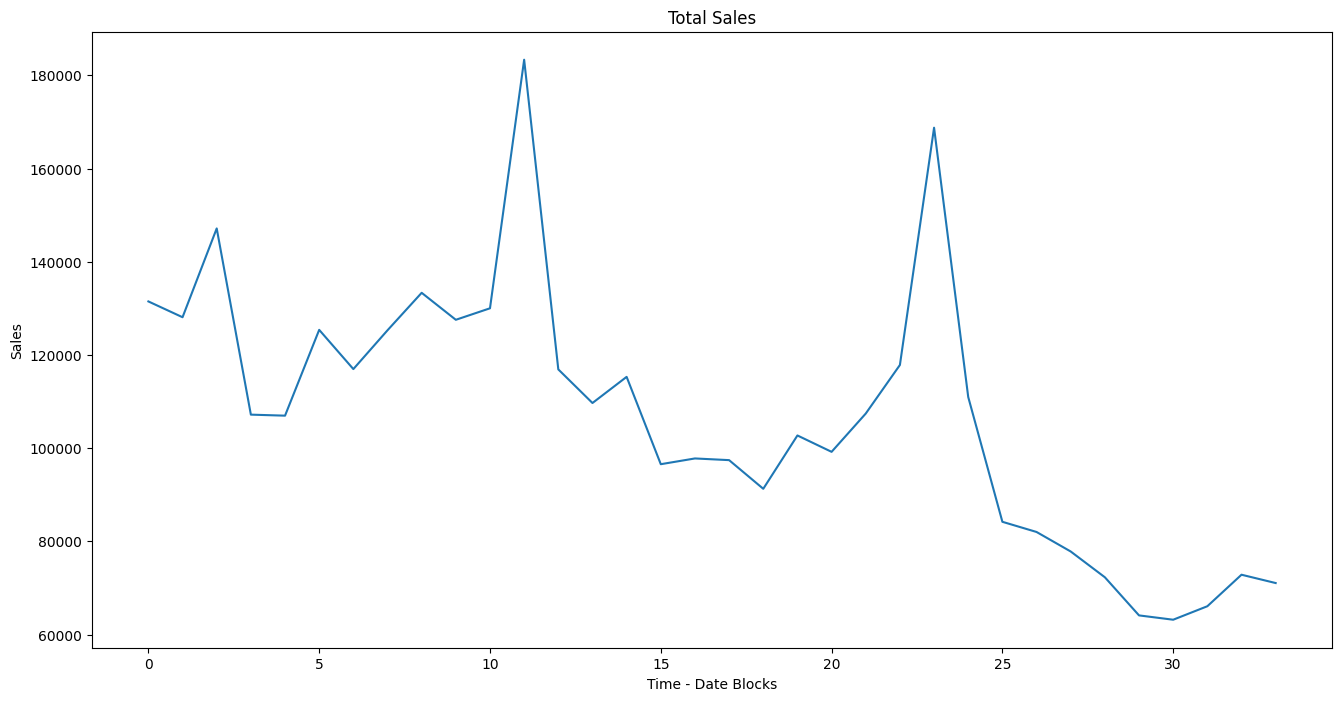

In [11]:
# data block num 별 상품 구매 건수 합계
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')

plt.figure(figsize=(16,8))
plt.plot(ts)
plt.xlabel('Time - Date Blocks')
plt.ylabel('Sales')
plt.title('Total Sales')

plt.show()

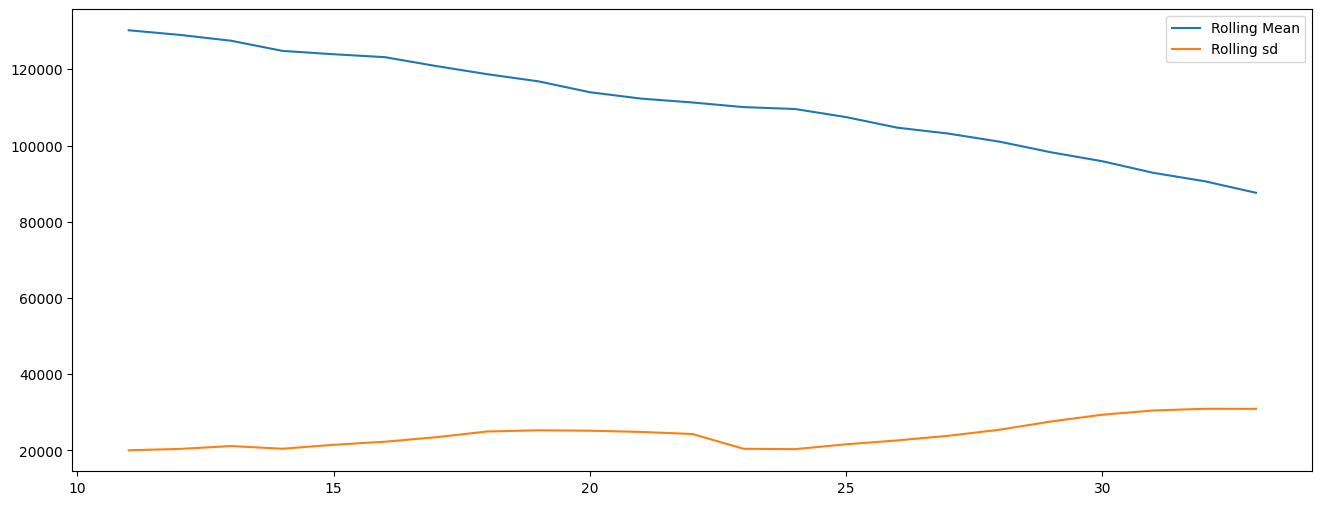

In [12]:
plt.figure(figsize=(16,6))

plt.plot(ts.rolling(window=12, center=False).mean(),label='Rolling Mean')
plt.plot(ts.rolling(window=12, center=False).std(),label='Rolling sd')

plt.legend()
plt.show()

<Figure size 1600x1200 with 0 Axes>

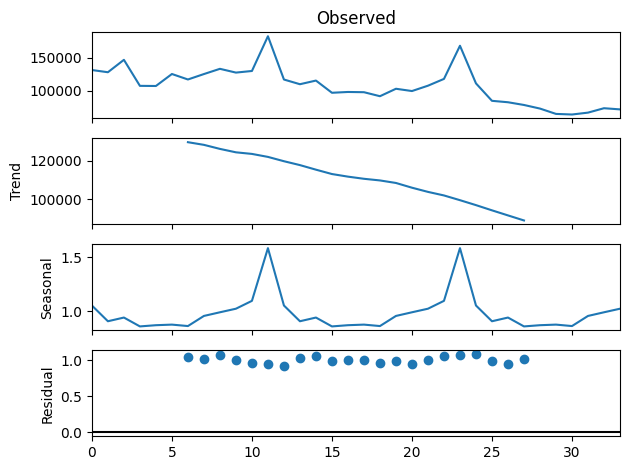

In [13]:
import statsmodels.api as sm

# multiplicative
res = sm.tsa.seasonal_decompose(ts.values , period=12, model="multiplicative")
plt.figure(figsize=(16, 12))

res.plot()
plt.show()

<Figure size 1600x1200 with 0 Axes>

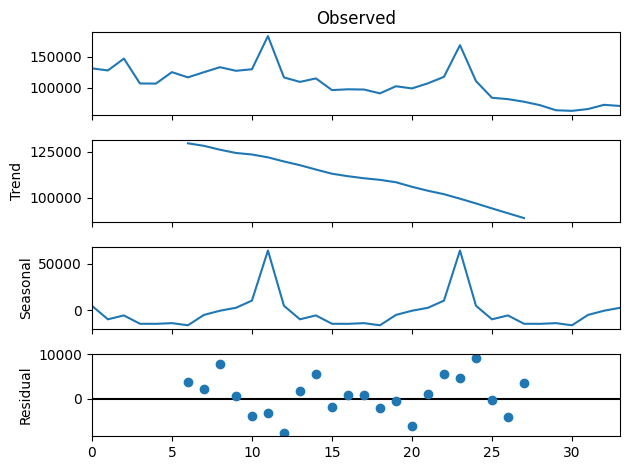

In [14]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="additive")
plt.figure(figsize=(16, 12))

res.plot()
plt.show()

In [15]:
# Testing for Stationarity
def test_stationarity(timeseries):

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
# Lags Used                     0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [16]:
# Remove Trend (t) component
from pandas import Series as Series

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)

    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

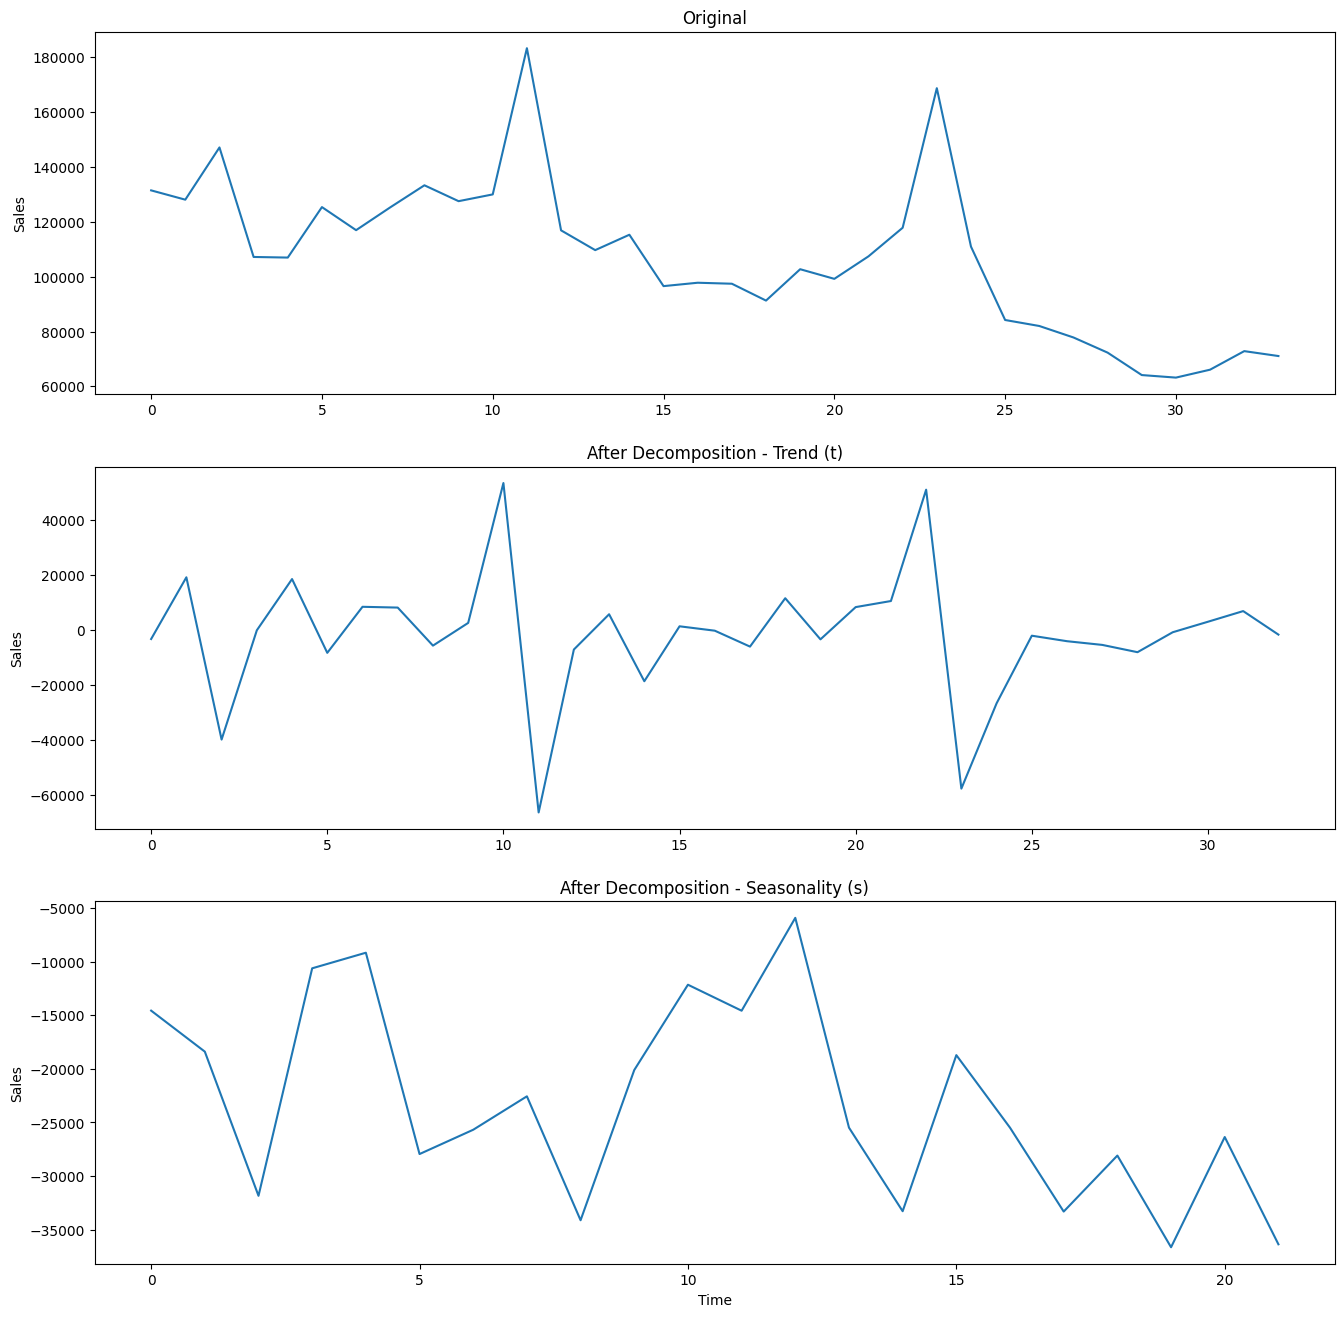

In [17]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')

plt.figure(figsize=(16,16))

plt.subplot(311)
plt.title('Original')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After Decomposition - Trend (t)')
plt.ylabel('Sales')
new_ts = difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After Decomposition - Seasonality (s)')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts, 12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

# Prophet 수요 예측

In [18]:
from prophet import Prophet

In [19]:
# Add dates to Time-series as index
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index = pd.date_range(start='2013-01-01', end='2015-10-01', freq='MS') # Month Start
ts = ts.reset_index()

ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [20]:
ts.columns = ['ds','y']

In [21]:
# model = Prophet(model_params)
model = Prophet(yearly_seasonality=True)  # Intantiate the model
model

In [22]:
# Prophet params
# Example

# growth(values = c("linear", "logistic"))

# changepoint_num(range = c(10L, 50L), trans = NULL)
# changepoint_range(range = c(0.6, 0.9), trans = NULL)

# seasonality_yearly(values = c(TRUE, FALSE))
# seasonality_weekly(values = c(TRUE, FALSE))
# seasonality_daily(values = c(TRUE, FALSE))

# prior_scale_changepoints(range = c(-3, 2), trans = log10_trans())
# prior_scale_seasonality(range = c(-3, 2), trans = log10_trans())
# prior_scale_holidays(range = c(-3, 2), trans = log10_trans())

In [23]:
model = Prophet(yearly_seasonality=True) # Prophet object can only be fit once. Instantiate a new object when running multiple times
model.fit(ts) # fit the model

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm4t1nvbb/_d5iu7mi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm4t1nvbb/mg5umon7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27253', 'data', 'file=/tmp/tmpm4t1nvbb/_d5iu7mi.json', 'init=/tmp/tmpm4t1nvbb/mg5umon7.json', 'output', 'file=/tmp/tmpm4t1nvbb/prophet_model619aoo7j/prophet_model-20240705011759.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:17:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:17:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# 예측 결과

In [24]:
# Predict for five months in the furure
future = model.make_future_dataframe(periods=5, freq='MS')  # MS - month start
forecast = model.predict(future)

In [25]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,141678.080526,128924.541733,135193.074426,141678.080526,141678.080526,-9566.715725,-9566.715725,-9566.715725,-9566.715725,-9566.715725,-9566.715725,0.0,0.0,0.0,132111.364801
1,2013-02-01,139958.249760,127948.401512,134261.041862,139958.249760,139958.249760,-8928.908479,-8928.908479,-8928.908479,-8928.908479,-8928.908479,-8928.908479,0.0,0.0,0.0,131029.341282
2,2013-03-01,138404.854230,144919.806106,151261.535384,138404.854230,138404.854230,9641.516639,9641.516639,9641.516639,9641.516639,9641.516639,9641.516639,0.0,0.0,0.0,148046.370870
3,2013-04-01,136685.023457,104393.438063,110664.288309,136685.023457,136685.023457,-29103.331645,-29103.331645,-29103.331645,-29103.331645,-29103.331645,-29103.331645,0.0,0.0,0.0,107581.691812
4,2013-05-01,135020.671086,104289.596912,110639.231680,135020.671086,135020.671086,-27684.157399,-27684.157399,-27684.157399,-27684.157399,-27684.157399,-27684.157399,0.0,0.0,0.0,107336.513687


In [26]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.967155,80094.130568,86215.983241
35,2015-12-01,125513.232658,122356.367985,128734.444644
36,2016-01-01,75625.686136,72543.002710,78942.796664
37,2016-02-01,40109.307915,36998.061167,43422.011354
38,2016-03-01,76664.068314,73434.945266,79678.299230


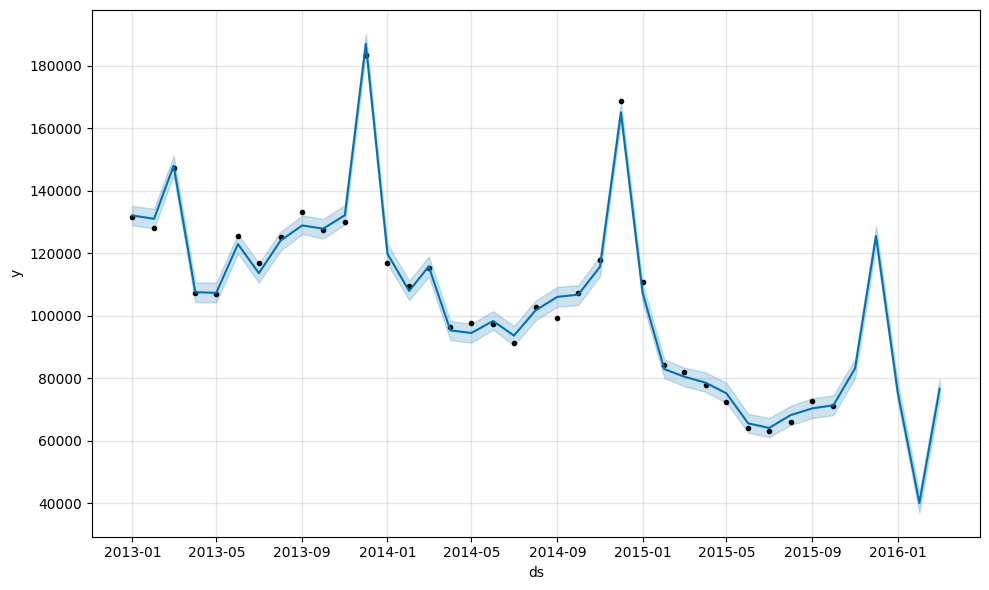

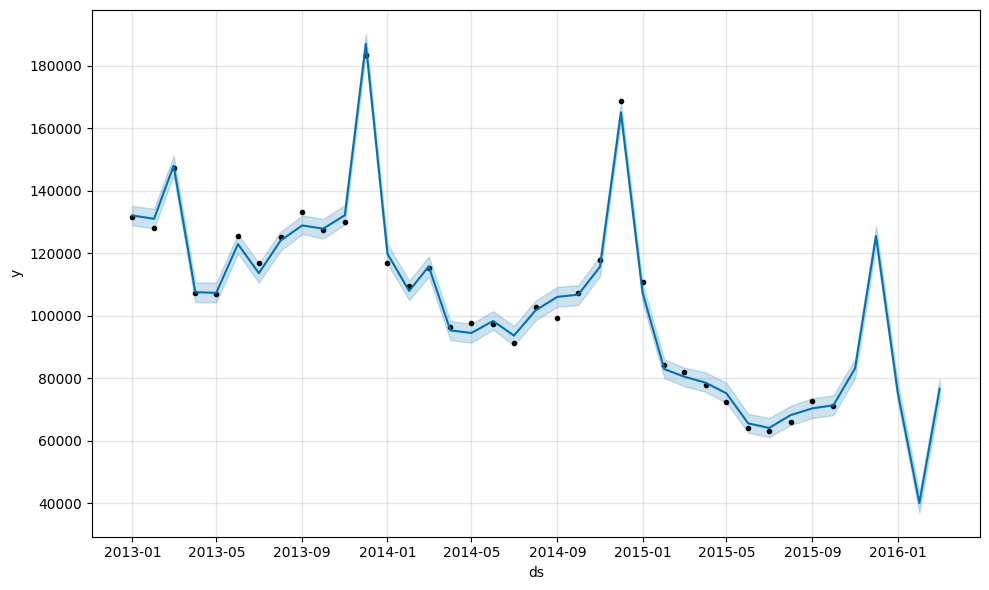

In [27]:
model.plot(forecast)

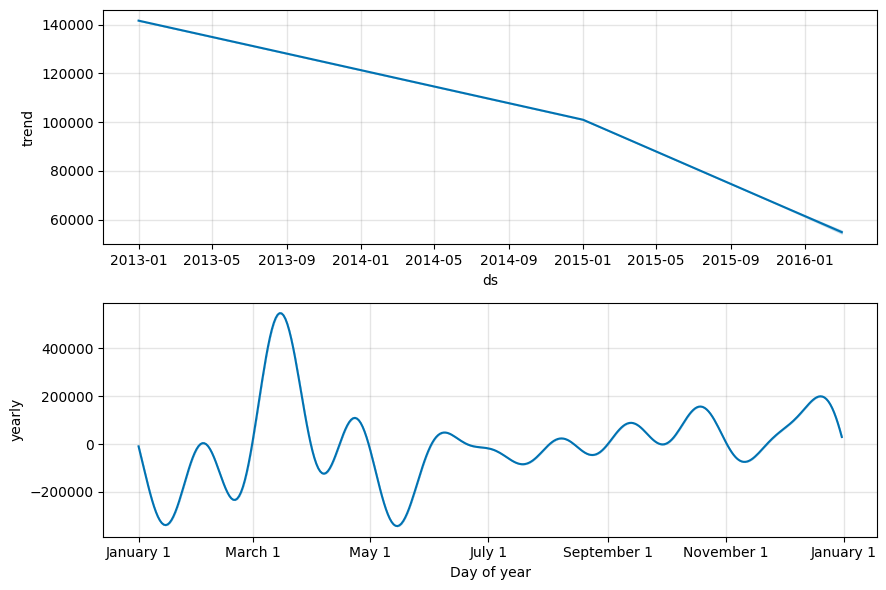

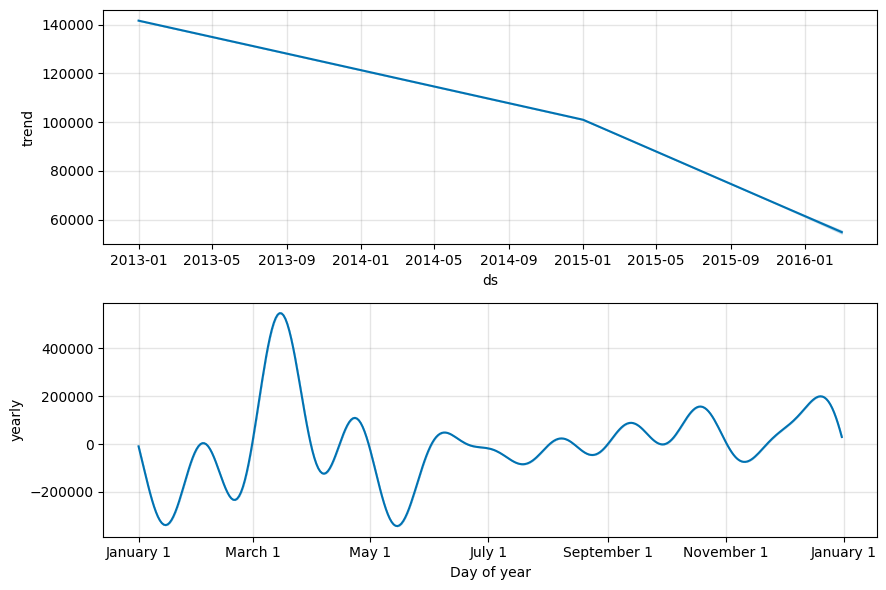

In [28]:
# plot the model forecast chart with component charts in trend and seasonality
model.plot_components(forecast)

In [29]:
# Show all forecasting values in a table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,132111.364801,128924.541733,135193.074426
1,2013-02-01,131029.341282,127948.401512,134261.041862
2,2013-03-01,148046.370870,144919.806106,151261.535384
3,2013-04-01,107581.691812,104393.438063,110664.288309
4,2013-05-01,107336.513687,104289.596912,110639.231680
5,2013-06-01,122945.911498,119963.402159,126215.642310
6,2013-07-01,113630.281087,110646.131731,116768.306843
7,2013-08-01,124068.202812,120830.223121,126923.192304
8,2013-09-01,128923.845408,126125.788169,132118.536929
9,2013-10-01,127879.371569,124761.998342,131003.089229
